<a href="https://colab.research.google.com/github/jmestanza/Echo_cancellation/blob/master/HistogramaDeT60dB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
#from numpy import random
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
""" Example for computing the RIR between several sources and receivers in GPU.
"""
!pip install https://github.com/DavidDiazGuerra/gpuRIR/zipball/master

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from math import ceil

import gpuRIR
gpuRIR.activateMixedPrecision(False)

room_sz = [3,3,2.5]  # Size of the room [m]
nb_src = 1  # Number of sources

max_list = []

for i in range(100):
    x = "{0:.1f}".format(np.random.uniform(0.5,2))
    y = "{0:.1f}".format(np.random.uniform(0.5,2))
    z = "{0:.1f}".format(np.random.uniform(0.5,1))
    x = float(x)
    y = float(y)
    z = float(z)

    pos_src = np.array([[x,y,z]]) # Positions of the sources ([m]
    nb_rcv = 1 # Number of receivers
    pos_rcv = np.array([[3/2,3/2,2.5/2]])	 # Position of the receivers [m]
    orV_rcv = np.matlib.repmat(np.array([0,1,0]), nb_rcv, 1) # Vectors pointing in the same direction than the receivers
    mic_pattern = "card" # Receiver polar pattern
    abs_weights = [0.9]*5+[0.5] # Absortion coefficient ratios of the walls
    T60 = 1.0	 # Time for the RIR to reach 60dB of attenuation [s]
    att_diff = 15.0	# Attenuation when start using the diffuse reverberation model [dB]
    att_max = 60.0 # Attenuation at the end of the simulation [dB]
    fs=16000.0 # Sampling frequency [Hz]

    beta = gpuRIR.beta_SabineEstimation(room_sz, T60, abs_weights=abs_weights) # Reflection coefficients
    Tdiff= gpuRIR.att2t_SabineEstimator(att_diff, T60) # Time to start the diffuse reverberation model [s]
    Tmax = gpuRIR.att2t_SabineEstimator(att_max, T60)	 # Time to stop the simulation [s]
    nb_img = gpuRIR.t2n( Tdiff, room_sz )	# Number of image sources in each dimension
    RIRs = gpuRIR.simulateRIR(room_sz, beta, pos_src, pos_rcv, nb_img, Tmax, fs, Tdiff=Tdiff, orV_rcv=orV_rcv, mic_pattern=mic_pattern)

    t = np.arange(int(ceil(Tmax * fs))) / fs
    impulse_response =RIRs.reshape(nb_src*nb_rcv, -1).transpose()
    max_list.append(np.amax(impulse_response))
     
    #plt.plot(t,impulse_response )
    #plt.show()

     - 706kB 541kB/s
  Created wheel for gpuRIR: filename=gpuRIR-1.2.0-cp36-cp36m-linux_x86_64.whl size=907221 sha256=9c3a896cd9d7a85dd6e7d4c4d825e611c014dfb1ea0e0b496b4edfc65e167346
  Stored in directory: /tmp/pip-ephem-wheel-cache-5zgtptsu/wheels/d6/80/3f/6af7d0e500b38d174f793d6b8ff6a0984b1eab8b2c8f6665ae
Successfully built gpuRIR


In [0]:
from IPython.display import clear_output

!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/originales/music_original.wav"
!wget "https://raw.githubusercontent.com/jmestanza/Guia_2_PASA/master/data/grabados/grab_cassiopeia.wav"

clear_output()

In [35]:
import math
from scipy.signal import find_peaks
!pip install wavio
import wavio
import numpy as np
import matplotlib.pyplot as plt

def get_mono_array2(stereo_file_name):
    file = wavio.read(stereo_file_name)
    return file.rate, file.data

def get60dbtime(wav_file_name):
    fs, arr_list = get_mono_array2(wav_file_name)
    #plt.plot(arr_list)
    arr = np.array(arr_list)
    max_abs = abs(np.amax(arr))
    min_abs = abs(np.amin(arr))
    abs_max = max(max_abs,min_abs)
    abs_60db = abs_max/(10**(60/20))
    found = False
    index_found = None
    i = 0
    index_list = []
    while i< len(arr):
        if abs_60db <= abs(arr[i]) :
            index_list.append(i)
        i+=1
    #plt.plot(arr_list)
    #plt.axvline(x = index_list[-1],linewidth=4, color='r')
    #print(index_list)
    time_60db = int(index_list[-1])/fs
    return time_60db,fs

In [36]:
t60_list = []
t60, fs = get60dbtime("Room001-00001.wav")
print("Room001-00001.wav con ",t60,"segs a ", fs,"Hz")
t60_list.append(t60)
t60, fs = get60dbtime("00x00y.wav")
print("Room001-00001.wav con ",t60,"segs a ", fs,"Hz")
t60_list.append(t60)
t60, fs = get60dbtime("Room001-00002.wav")
print("Room001-00001.wav con ",t60,"segs a ", fs,"Hz")
t60_list.append(t60)

Room001-00001.wav con  0.157875 segs a  16000 Hz
Room001-00001.wav con  1.9999895833333334 segs a  96000 Hz
Room001-00001.wav con  0.2835 segs a  16000 Hz


(0.0, 10.0)

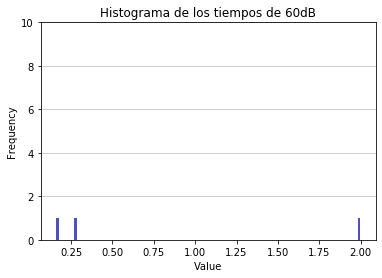

In [37]:
n, bins, patches = plt.hist(x=t60_list, bins=100, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de los tiempos de 60dB')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)